# Задача №6

Необходимо решить задачу классификации для определения пола человека по изображению. При этом дана выборка (~200 тыс. фотографий) CelebA с изображениями знаменитых людей ( http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html ).

## I. Обработка данных в датасете

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
#from keras.utils import np_utils

C:\Users\Plumite Elvira\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Избавляемся от лишних пробелов

In [2]:
f = open('list_attr_celeba.txt', "r")
ff = open('attr.txt', "w")
for line in f:
    line = line.replace("  ", " ")
    ff.write(line.replace(" ", ","))
f.close()
ff.close()

### Описание данных

В датасете представлено **202599** фотографий знаменитостей и соответствующие им два набора признаков: *бинарные* (наличие бороды, улыбки, длинных волос и т.п.) и *категориальные* (координаты расположения глаз, носа, рта, размеры фотографии)

А теперь подробнее ... 

1. Количество фотографий: **202599**
2. Количество уникальных личностей: **10177** (для определения пола не играет роли)
3. Количество категориальных признаков: **5**
4. Количество бинарных признаков: **39+1**, включая метку класса (**М/Ж**)

Наличие бинарного признака обозначается как "1", отсутствие - "-1" соответственно. Далее будем работать с бинарными признаками

In [3]:
data = pd.read_csv('attr.txt', dtype = 'str')

In [4]:
data = data.drop(['File'], axis=1)
data = data.apply(pd.to_numeric)
data.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Посмотрим, какие признаки есть в таблице, и выведем информацию о данных. Видим, что нет пропусков.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 40 columns):
5_o_Clock_Shadow       202599 non-null int64
Arched_Eyebrows        202599 non-null int64
Attractive             202599 non-null int64
Bags_Under_Eyes        202599 non-null int64
Bald                   202599 non-null int64
Bangs                  202599 non-null int64
Big_Lips               202599 non-null int64
Big_Nose               202599 non-null int64
Black_Hair             202599 non-null int64
Blond_Hair             202599 non-null int64
Blurry                 202599 non-null int64
Brown_Hair             202599 non-null int64
Bushy_Eyebrows         202599 non-null int64
Chubby                 202599 non-null int64
Double_Chin            202599 non-null int64
Eyeglasses             202599 non-null int64
Goatee                 202599 non-null int64
Gray_Hair              202599 non-null int64
Heavy_Makeup           202599 non-null int64
High_Cheekbones        202599 non-

In [6]:
data['Male'].value_counts()

-1    118165
 1     84434
Name: Male, dtype: int64

Так что количество фотографий каждого из классов примерно одинковое: 42% для мужчин и 58% для девушек.

In [7]:
data.shape

(202599, 40)

Составляем столбец значений целевой переменной

In [8]:
y = data[['Male']]

In [9]:
y.head()

,Male
0,-1
1,-1
2,1
3,-1
4,-1


И матрицу объектов-признаков:

In [10]:
x = data.drop(['Male'], axis=1)

In [11]:
x.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


### Анализ качества выборки

In [12]:
male = data[data['Male'] == 1]
female = data[data['Male'] == -1]

C:\Users\Plumite Elvira\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


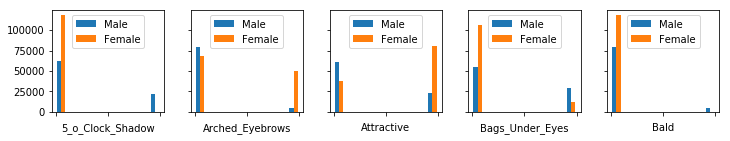

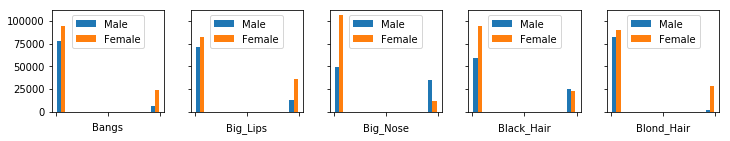

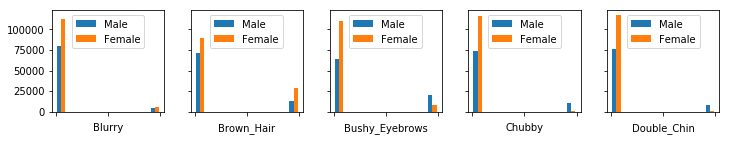

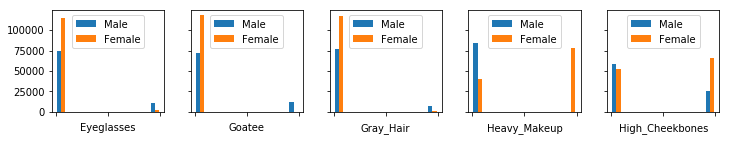

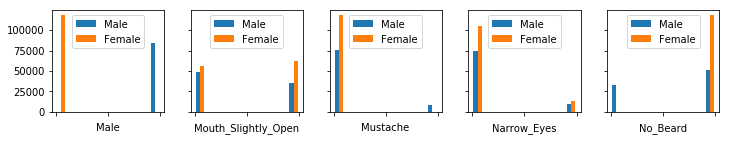

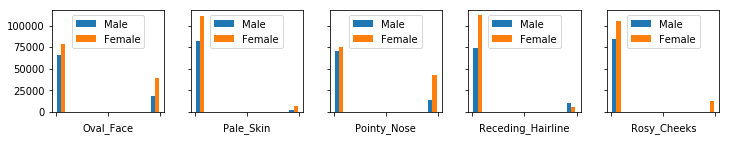

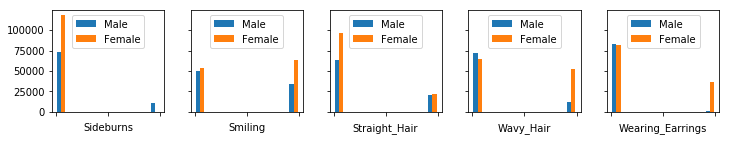

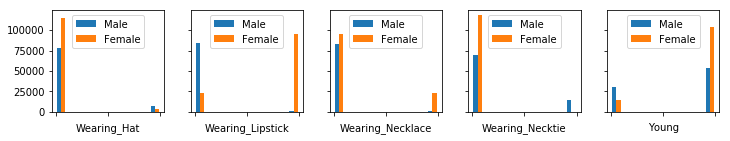

In [13]:
f = []
ax = []
for _ in range(8):
    fig, axes = plt.subplots(1, 5, sharey=True, figsize=(10,2))
    fig.subplots_adjust(hspace=0.05, wspace=0.2)
    fig.tight_layout()
    f.append(fig)
    ax.append(axes)
for j, i in enumerate(male.columns[0:]):
    ax[j//5][j%5].hist([male[i],female[i]], histtype = 'bar', label = ['Male', 'Female'])
    ax[j//5][j%5].set_xticklabels('')
    ax[j//5][j%5].legend(loc='upper center')
    ax[j//5][j%5].set_xlabel(i)
plt.show()

Видим, что из всех признаков *наименее* информативными для задачи по определению пола являются: **Bangs**, **Big_Lips**, **Brown_Hair**, **Oval_Face**

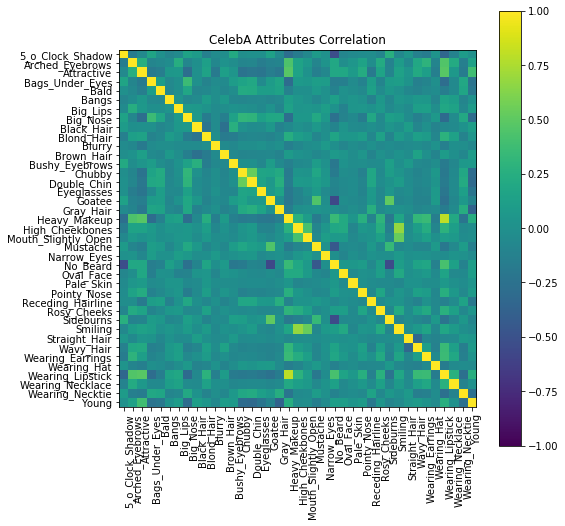

In [14]:
figure, a = plt.subplots(figsize=(8,8))
cmap=a.imshow(x.corr(), vmax=1, vmin=-1)

# add all ticks
a.set_xticks(np.arange(len(x.columns)))
a.set_yticks(np.arange(len(x.columns)))
a.set_xticklabels(x.columns)
a.set_yticklabels(x.columns)

# rotate x_ticks
plt.setp(a.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# annotate colormap
plt.title("CelebA Attributes Correlation")
plt.colorbar(mappable=cmap, ax=a)
plt.show()

По корреляционной матрице видим, что признаки достаточно слабо коррелируют друг с другом, поэтому можно оставить все признаки. Но сильнее всего коррелируют: **No beard - 5_o_Clock_Shadow**, **No beard - Goatee**, **No beard - Mustache**, **No beard - Sideburns**, поэтому, врзможно, стоит убрать **No beard** из признаков

In [15]:
x = x.drop('No_Beard',axis=1)

### Разделение выборки на обучающую и тестовую

В данном датасете уже было произведено разделение на **train/test/validate** sample.

In [16]:
partition = pd.read_csv('list_eval_partition.txt', dtype='str', sep=' ')
partition = partition.drop('File', axis=1)
partition = pd.to_numeric(partition['Type'])
partition.head()

0    0
1    0
2    0
3    0
4    0
Name: Type, dtype: int64

Теперь, зная раcпределение, составвим соответствующие выборки: x_train, x_test

In [17]:
data['Type'] = pd.Series(partition, index=x.index)
data.head()

x_train = data[data['Type'] != 2]
x_test = data[data['Type'] == 2]

y_train = x_train['Male']
y_test = x_test['Male']

x_train = x_train.drop(['Male', 'Type', 'No_Beard'], axis=1)
x_test = x_test.drop(['Male', 'Type', 'No_Beard'], axis=1)

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((182637, 38), (182637,), (19962, 38), (19962,))

## II. Модели

### K-NN (структурный параметр: количество соседей, критерий качества: ROC AUC)
Сначала определим оптимальное число соседей по выборке из 10000 экземпляров.

In [19]:
roc_auc_mean = []
roc_auc_std = []

for n in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=n)
    score = cross_val_score(knn, x_train[:10000], y_train[:10000], scoring=metrics.make_scorer(metrics.roc_auc_score), cv=3)
    roc_auc_mean.append(np.mean(score))
    roc_auc_std.append(np.std(score))

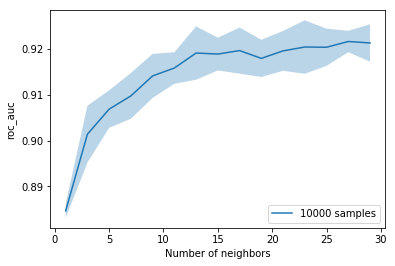

In [20]:
mean_min=[]
mean_max=[]
neighbors=np.arange(1,30,2)

for i,_ in enumerate(neighbors):
    mean_min.append(roc_auc_mean[i] - roc_auc_std[i])
    mean_max.append(roc_auc_mean[i] + roc_auc_std[i])

plt.plot(neighbors, roc_auc_mean)
plt.fill_between(neighbors,mean_min, mean_max, alpha=0.3)
plt.xlabel('Number of neighbors')
plt.ylabel('roc_auc')
plt.legend(['10000 samples'], loc='lower right')

По графику видно, что оптимальное число соседей: **15**. Посчитаем roc_auc_score для этого числа соседей по всей выборке.

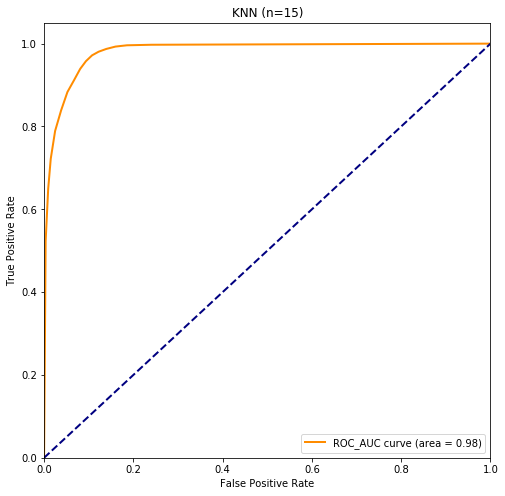

In [22]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_train, y_train)

pred = knn.predict(x_test)
y_train_prob = knn.predict_proba(x_test)

fpr, tpr, _ = metrics.roc_curve(y_test, y_train_prob[:, 1])
rocauc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC_AUC curve (area = %0.2f)' % rocauc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN (n=15)')
plt.legend(loc="lower right")
plt.show()

In [23]:
mean = roc_auc_mean[6]
std = roc_auc_std[6] 
print('roc_auc_score = '+ str(mean) + ' +- ' + str(std))

roc_auc_score = 0.9190981795462815 +- 0.005815870283370075


### SVM (структурный параметр: С, критерий качества: ROC AUC)
Сначала подберем параметр С на выборке из 10000 экземпляров

In [24]:
roc_auc_mean = []
roc_auc_std = []

Const_ = []
for i in range(5, 105, 20):
    Const_.append(i*0.01)

for C in Const_:
    clf = SVC(probability=True, C=C)
    score = cross_val_score(clf, x_train[:10000], y_train[:10000], scoring=metrics.make_scorer(metrics.roc_auc_score), cv=3)
    roc_auc_mean.append(np.mean(score))
    roc_auc_std.append(np.std(score))

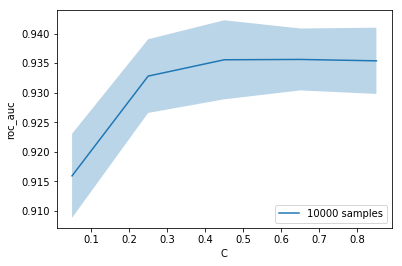

In [25]:
mean_min=[]
mean_max=[]

for i,_ in enumerate(Const_):
    mean_min.append(roc_auc_mean[i] - roc_auc_std[i])
    mean_max.append(roc_auc_mean[i] + roc_auc_std[i])

plt.plot(Const_, roc_auc_mean)
plt.fill_between(Const_,mean_min, mean_max, alpha=0.3)
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['10000 samples'], loc='lower right')

По графику видно, что оптимальная константа: 0.5. Посчитаем roc_auc_score для нее.

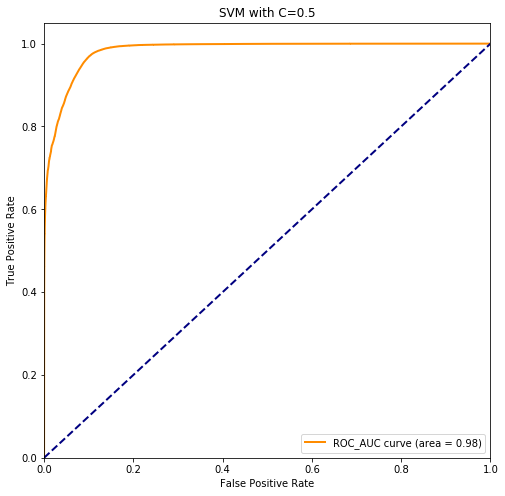

In [26]:
clf = SVC(probability=True, C=0.5)
clf.fit(x[:10000], np.ravel(y[:10000]))
pred = clf.predict(x[10000:])
y_prob = clf.predict_proba(x[10000:])

fpr, tpr, _ = metrics.roc_curve(np.ravel(y[10000:]), y_prob[:, 1])
rocauc = metrics.auc(fpr, tpr)
    
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC_AUC curve (area = %0.2f)' % rocauc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM with C=0.5')
plt.legend(loc="lower right")
plt.show()

In [27]:
mean = roc_auc_mean[2]
std = roc_auc_std[2]
print('roc_auc_score = '+ str(mean) + ' +- ' + str(std))

roc_auc_score = 0.9355607974203956 +- 0.006681847047923096


### Нейронная сеть с одним скрытым слоем (структурный параметр: количество итераций оптимизации нейронной сети, количество нейронов на скрытом слое, критерий качества: ROC AUC)
Подберем параметры сети на выборке из 10000 экземпляров

In [28]:
# initialise attributes of network
neurons = 15
epochs = 2
batch = 500

In [29]:
# add roc_auc metrics for keras
from sklearn.metrics import roc_auc_score
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.mean = [] 


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = metrics.roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = metrics.roc_auc_score(self.y_val, y_pred_val)
        self.mean.append(roc_val)       
#        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

Text(0.5,1,'Network with hidden layer')

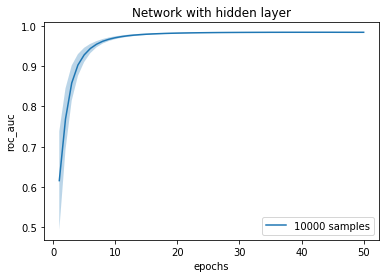

In [30]:
# observe accuracy according to epochs
from sklearn.model_selection import StratifiedKFold

neurons = 15
epochs = 50
batch = 500

mean_epochs = []
std_epochs = []
mean = []

def roc_auc_score(x_train, y_train, x_test, y_test, epochs, batch, neurons):
    mean_epochs = []
    model = Sequential()

    # hidden layer
    model.add(Dense(neurons, input_dim=x_train.shape[1], activation='relu'))
    # output layer
    model.add(Dense(1, activation='tanh'))

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

    roc_auc = roc_callback(training_data=(x_train, y_train),
    validation_data=(x_test, y_test))

    history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
    callbacks=[roc_auc], epochs=epochs, batch_size=batch, verbose=0)

    mean_epochs = roc_auc.mean
    
    return mean_epochs

X = np.array(x_train[:10000])
Y = np.array(y_train[:10000])

for i in range(3):
    skf = StratifiedKFold(n_splits=3, random_state=42)
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
    mean.append(roc_auc_score(X_train, Y_train, X_test, Y_test, epochs, batch, neurons))
    
for i in range(epochs):
    mean_epochs.append(np.mean([mean[0][i],mean[1][i],mean[2][i]]))
    std_epochs.append(np.std([mean[0][i],mean[1][i],mean[2][i]]))
    
# plot the tendency
mean_min=[]
mean_max=[]

for i in range(epochs):
    mean_min.append(mean_epochs[i] - std_epochs[i])
    mean_max.append(mean_epochs[i] + std_epochs[i])

plt.plot(np.arange(1,epochs+1), mean_epochs)
plt.fill_between(np.arange(1,epochs+1),mean_min, mean_max, alpha=0.3)
plt.legend(['10000 samples'], loc='lower right')
plt.xlabel('epochs')
plt.ylabel('roc_auc')
plt.title('Network with hidden layer')

Видим, что оптимальное число эпох: **10**, перейдем к изучению размера батча

Text(0.5,1,'Network with hidden layer')

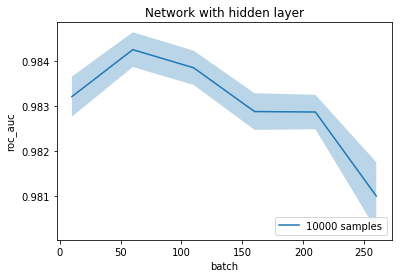

In [31]:
neurons = 15
epochs = 10
batch = 500

mean = []
mean_batch = []
std_batch = []

X = np.array(x_train[:10000])
Y = np.array(y_train[:10000])

for batch in range(10, 300, 50):
    for i in range(3):
        skf = StratifiedKFold(n_splits=3, random_state=42)
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
        mean.append(roc_auc_score(X_train, Y_train, X_test, Y_test, epochs, batch, neurons)[epochs-1])
    mean_batch.append(np.mean(mean))
    std_batch.append(np.std(mean))
    mean = []
    
# plot the tendency
mean_min=[]
mean_max=[]

for i, _ in enumerate(np.arange(10, 300, 50)):
    mean_min.append(mean_batch[i] - std_batch[i])
    mean_max.append(mean_batch[i] + std_batch[i])

plt.plot(np.arange(10, 300, 50), mean_batch)
plt.fill_between(np.arange(10, 300, 50),mean_min, mean_max, alpha=0.3)
plt.legend(['10000 samples'], loc='lower right')
plt.xlabel('batch')
plt.ylabel('roc_auc')
plt.title('Network with hidden layer')

Видим, что оптимальное размер батча: **50**, перейдем к изучению зависимости ошибки от числа нейронов в скрытом слое

Text(0.5,1,'Network with hidden layer')

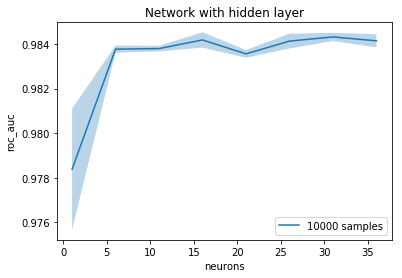

In [32]:
neurons = 15
epochs = 10
batch = 50

mean = []
mean_neurons = []
std_neurons = []

X = np.array(x_train[:10000])
Y = np.array(y_train[:10000])

for neurons in range(1,40,5):
    for i in range(3):
        skf = StratifiedKFold(n_splits=3, random_state=42)
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
        mean.append(roc_auc_score(X_train, Y_train, X_test, Y_test, epochs, batch, neurons)[epochs-1])
    mean_neurons.append(np.mean(mean))
    std_neurons.append(np.std(mean))
    mean = []
    
# plot the tendency
mean_min=[]
mean_max=[]

for i, _ in enumerate(np.arange(1,40,5)):
    mean_min.append(mean_neurons[i] - std_neurons[i])
    mean_max.append(mean_neurons[i] + std_neurons[i])
plt.plot(np.arange(1,40,5), mean_neurons)
plt.fill_between(np.arange(1,40,5),mean_min, mean_max, alpha=0.3)
plt.legend(['10000 samples'], loc='lower right')
plt.xlabel('neurons')
plt.ylabel('roc_auc')
plt.title('Network with hidden layer')

Видим, что оптимальное число нейронов: **15**, проведем анализ для подобранных параметров.

In [33]:
neurons = 15
epochs = 10
batch = 50

mean = []

for i in range(3):
    skf = StratifiedKFold(n_splits=3, random_state=42)
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        mean.append(roc_auc_score(X_train, Y_train, X_test, Y_test, epochs, batch, neurons)[epochs-1])

print('roc_auc_score = '+ str(np.mean(mean)) + ' +- ' + str(np.std(mean)))

roc_auc_score = 0.9827655551458547 +- 0.0016653544727785997


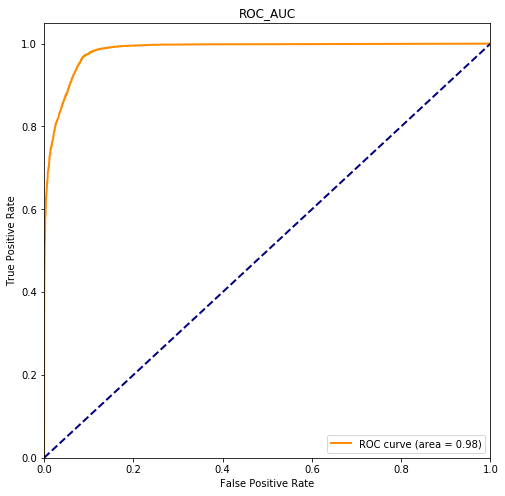

In [35]:
# Draw ROC_AUC curve and accuracy/loss plot for optimal network
neurons = 15
epochs = 10
batch = 50

model = Sequential()
    
# hidden layer
model.add(Dense(neurons, input_dim=x_train.shape[1], activation='relu'))
# output layer
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train[:10000], y_train[:10000], validation_data=(x_test[:1000], y_test[:1000]), epochs=epochs, batch_size=batch, verbose=0)
y_pred_prob = model.predict(x_test, batch_size=batch, verbose=0, steps=None).ravel()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
rocauc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % rocauc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC')
plt.legend(loc="lower right")
plt.show()

Лучшие показатели были у нейронной сети, поэтому проверим ее на всей выборке

## III. Итоговое исследование

In [36]:
neurons = 15
epochs = 10
batch = 50

model = Sequential()
    
# hidden layer
model.add(Dense(neurons, input_dim=x_train.shape[1], activation='relu'))
# output layer
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch, verbose=0)
y_pred_prob = model.predict(x_test, batch_size=batch, verbose=0, steps=None).ravel()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
rocauc = metrics.auc(fpr, tpr)

print(rocauc)

0.9784631796557793


Вывод: лучшей моделью оказалась нейронная сеть с одним скрытым слоем и ее результат - 97,8% по метрике ROC_AUC